# Clustering con Wavelets + K-Means

### Objetivo
Aplicar **Discrete Wavelet Transform (DWT)** para extraer características tiempo-frecuencia y evaluar clustering con K-Means.

### ¿Por qué Wavelets?
- FFT captura solo información de frecuencia (pierde localización temporal)
- DWT captura información **tiempo-frecuencia** simultáneamente
- Útil para señales no estacionarias donde el contenido frecuencial cambia en el tiempo

**Wavelet usada:** Daubechies 4 (`db4`) - común en análisis de vibraciones

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

sys.path.append('../utils')
from clustering_utils import load_paired_signals, evaluate_clustering
from wavelet_utils import apply_wavelet_to_pairs, extract_wavelet_features
from metrics_logger import ClusteringMetricsLogger

# Logger
RESULTS_FILE = 'clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print("Setup completado")

Setup completado


## 1. Carga de Pares de Señales (S2, S1)

In [2]:
# Cargar pares (S2, S1)
paired_data = load_paired_signals(
    signals_dir='../../data/Signals_Raw/',
    labels_csv='../../data/nivel_damage.csv',
    base_specimens_only=True,
    target_length=60000,
    verbose=True
)
print(f"\n✅ Cargados {len(paired_data)} pares de señales")

📋 PASO 1: Cargando etiquetas...
   ✓ Cargadas etiquetas para 71 especímenes

📂 PASO 2: Escaneando directorio ../../data/Signals_Raw/...
   ✓ Filtrado a 52 especímenes base (sin variantes -2, -3)

🔄 PASO 3: Cargando pares (S2, S1)...
   ✓ A1: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A10: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A11: 60,000 muestras → 60,000 (sin cambios) | N2 | Tipo C
   ✓ A12: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A13: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo C
   ✓ A14: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A15: 93,899 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A16: 87,999 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A17: 121,599 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A18: 104,899 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A19: 103,899 muestras → 60,000 (truncada) | N1 | Tipo nan
   ✓ A2: 60,000 muestras → 60,000 (sin cambios) | N1 | Tipo B
   ✓ A20: 99,69

### Inspección de los Datos Cargados

In [3]:
# Resumen de datos cargados
summary_df = pd.DataFrame([{
    'ID': p['specimen_id'],
    'Nivel': p['nivel_dano'],
    'Tipo': p['tipo']
} for p in paired_data])

print("Distribución por nivel de daño:")
print(summary_df['Nivel'].value_counts().sort_index())

Distribución por nivel de daño:
Nivel
N1    42
N2     7
N3     2
Name: count, dtype: int64


## 2. Aplicación de DWT (Discrete Wavelet Transform)

La DWT descompone la señal en:
- **cA** (aproximación): componentes de baja frecuencia
- **cD1, cD2, ...** (detalles): componentes de alta frecuencia en cada nivel

In [4]:
# Aplicar DWT (Daubechies 4, 5 niveles)
wavelet_data = apply_wavelet_to_pairs(paired_data, wavelet='db4', level=5)
print(f"DWT aplicado a {len(wavelet_data)} pares")

🔄 Aplicando DWT (db4, nivel=5) a cada par...
✅ DWT aplicado a 51 pares

DWT aplicado a 51 pares


### Inspección de Coeficientes Wavelet

In [5]:
# Estructura de coeficientes
first = wavelet_data[0]
dwt_s2 = first['dwt_S2']

print(f"Espécimen: {first['specimen_id']}")
print(f"Wavelet: {dwt_s2['wavelet']}")
print(f"Niveles: {dwt_s2['level']}")
print(f"\nCoeficientes por nivel (eje N-S):")
for i, coeff in enumerate(dwt_s2['coeffs'][0]):
    level_name = 'cA' if i == 0 else f'cD{dwt_s2["level"] - i + 1}'
    print(f"  {level_name}: {len(coeff)} coeficientes")

Espécimen: A1
Wavelet: db4
Niveles: 5

Coeficientes por nivel (eje N-S):
  cA: 1881 coeficientes
  cD5: 1881 coeficientes
  cD4: 3756 coeficientes
  cD3: 7506 coeficientes
  cD2: 15005 coeficientes
  cD1: 30003 coeficientes


## 3. Visualización de Coeficientes por Nivel de Daño

In [6]:
def get_specimens_by_damage(data: list, nivel: str, n: int = 1) -> list:
    """Obtiene hasta n especímenes de un nivel de daño."""
    return [p for p in data if p['nivel_dano'] == nivel][:n]


def get_specimens_by_id(data: list, specimen_ids: list) -> list:
    """Obtiene especímenes por IDs específicos."""
    return [p for p in data if p['specimen_id'] in specimen_ids]


def plot_wavelet_coefficients(pair: dict, figsize: tuple = (14, 8)):
    """Plotea coeficientes wavelet de S2 vs S1 para un espécimen."""
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    dwt_s2 = pair['dwt_S2']
    dwt_s1 = pair['dwt_S1']
    n_levels = dwt_s2['level']
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - {specimen_id}: Coeficientes Wavelet (db4)', fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    
    for col, axis_name in enumerate(axis_names):
        # S2 (fila 0)
        coeffs_s2 = dwt_s2['coeffs'][col]
        energies_s2 = [np.sum(c**2) for c in coeffs_s2]
        labels = ['cA'] + [f'cD{n_levels-i}' for i in range(n_levels)]
        
        axes[0, col].bar(labels, energies_s2, color='red', alpha=0.7, edgecolor='black')
        axes[0, col].set_title(f'S2 - {axis_name}')
        axes[0, col].set_ylabel('Energía')
        axes[0, col].tick_params(axis='x', rotation=45)
        
        # S1 (fila 1)
        coeffs_s1 = dwt_s1['coeffs'][col]
        energies_s1 = [np.sum(c**2) for c in coeffs_s1]
        
        axes[1, col].bar(labels, energies_s1, color='green', alpha=0.7, edgecolor='black')
        axes[1, col].set_title(f'S1 - {axis_name}')
        axes[1, col].set_ylabel('Energía')
        axes[1, col].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


print("Funciones de visualización definidas")

Funciones de visualización definidas


### Coeficientes N1 (Sin daño / Daño leve)

Especímenes N1: ['A1', 'A16', 'A2', 'A51']



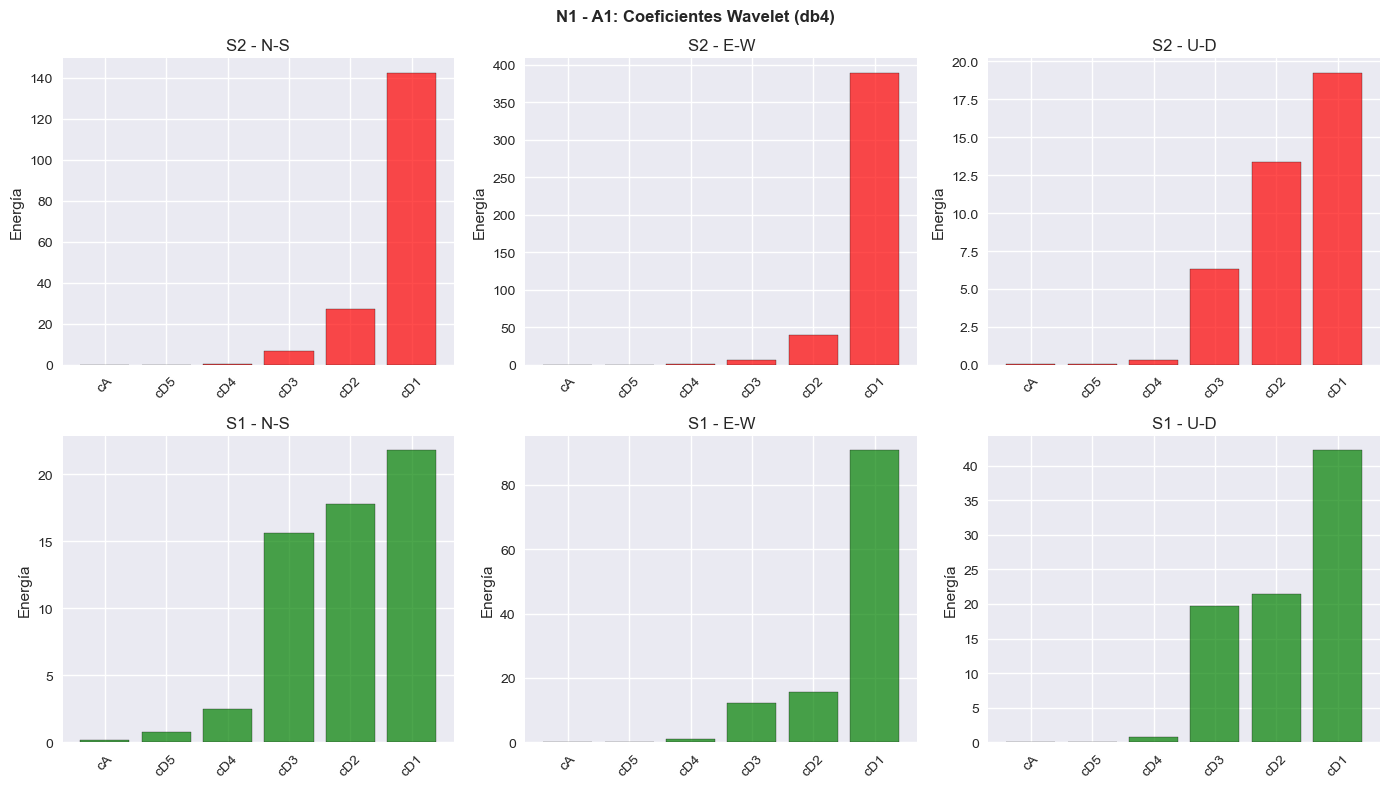

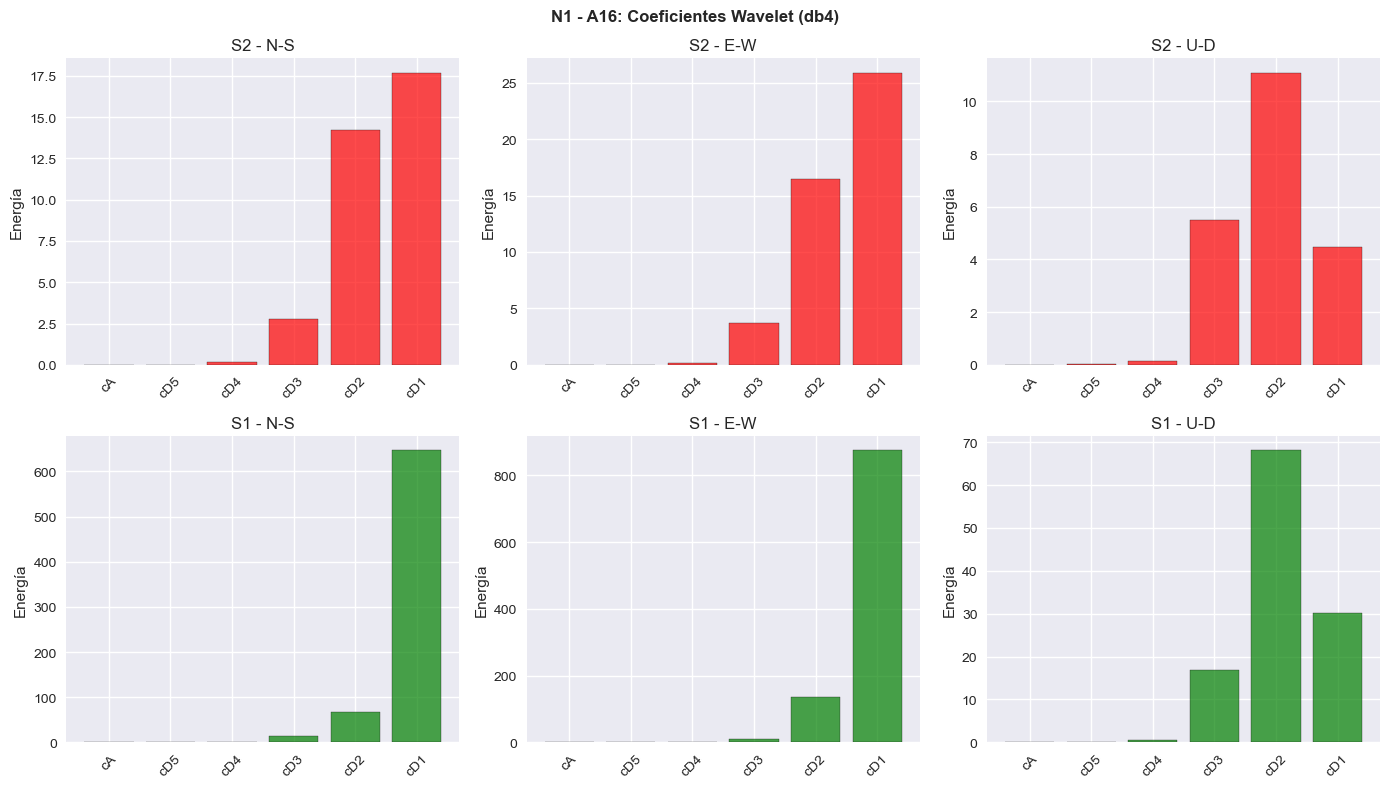

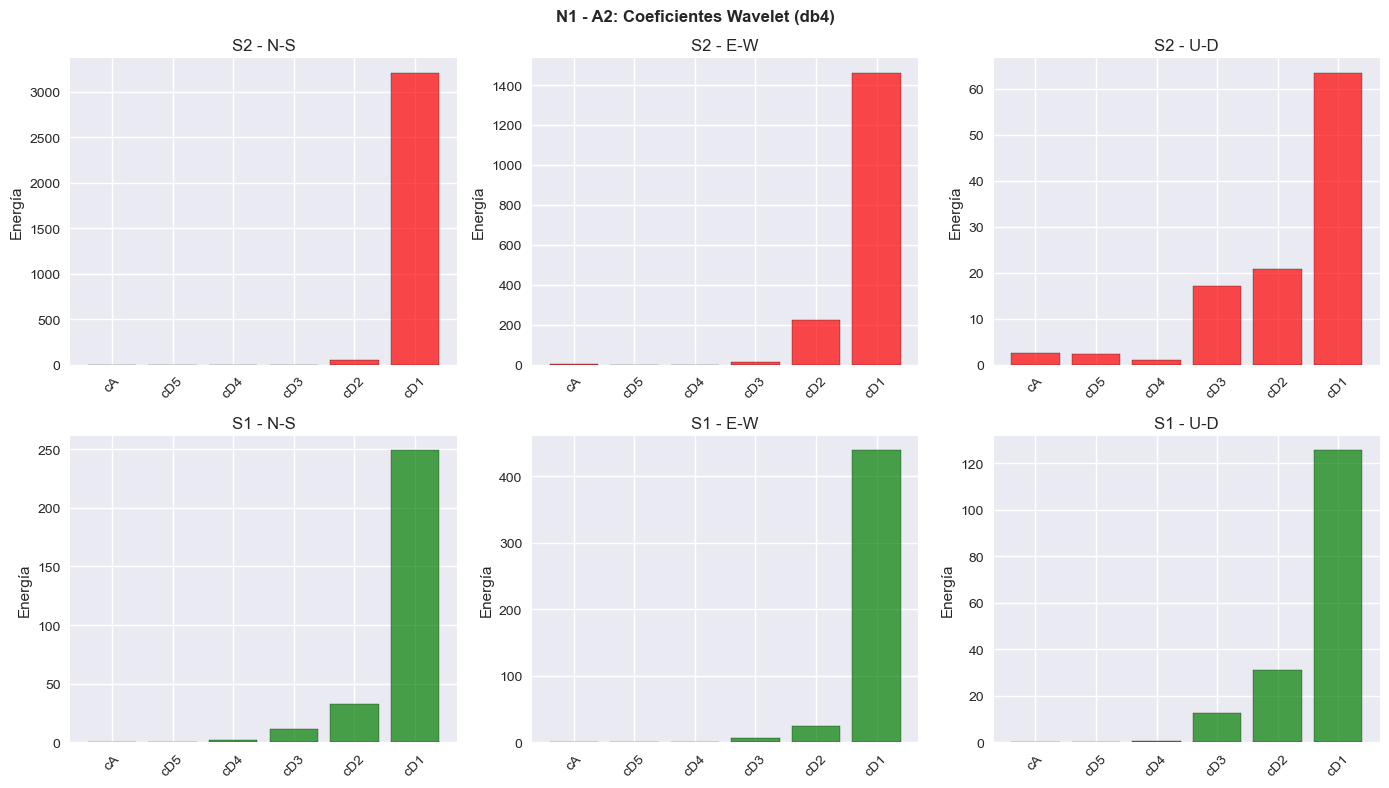

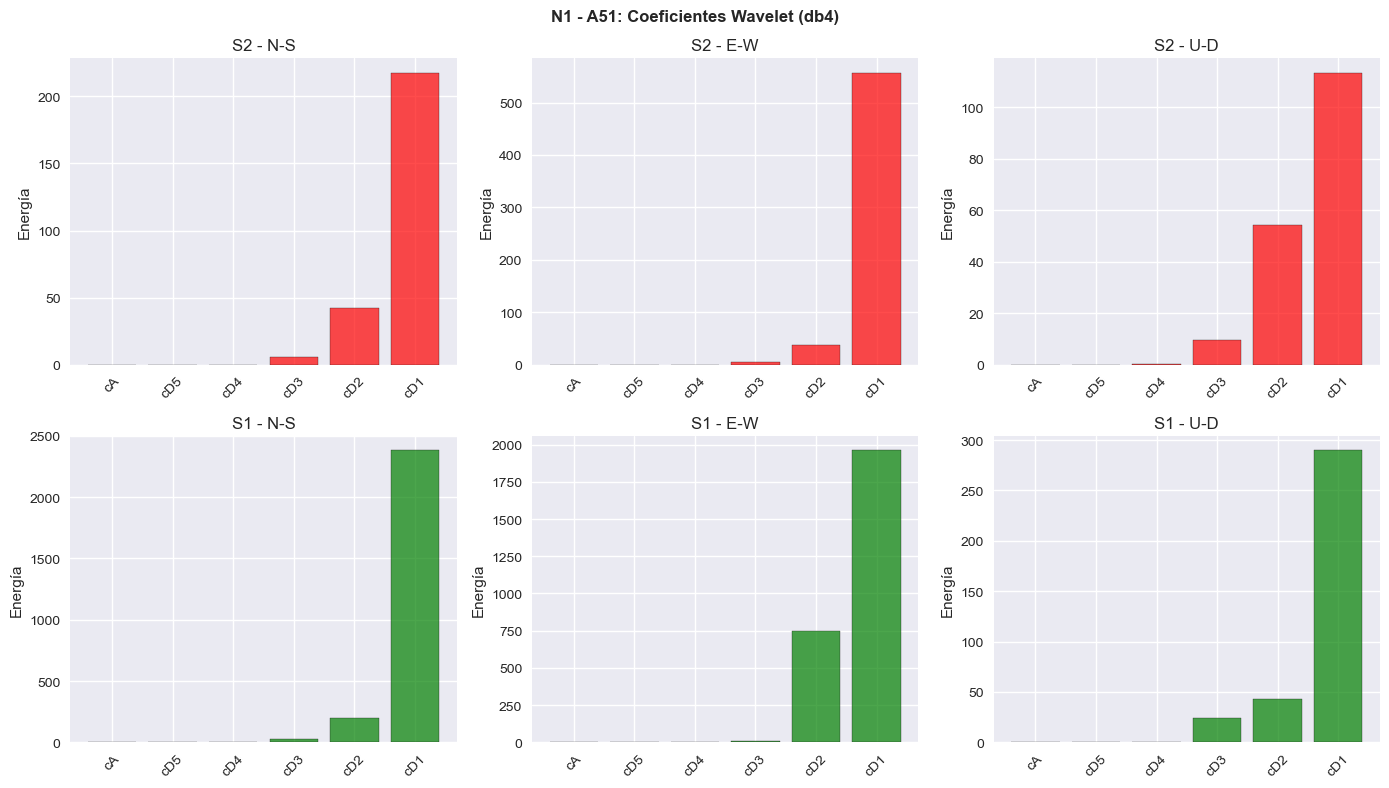

In [7]:
# Mismos especímenes que en notebook FFT para comparación justa
specimens_n1 = get_specimens_by_id(wavelet_data, ['A1', 'A2', 'A16', 'A51'])
print(f"Especímenes N1: {[s['specimen_id'] for s in specimens_n1]}\n")

for specimen in specimens_n1:
    plot_wavelet_coefficients(specimen)

### Coeficientes N2 (Daño moderado)

Especímenes N2: ['A23', 'A25', 'A8', 'A9']



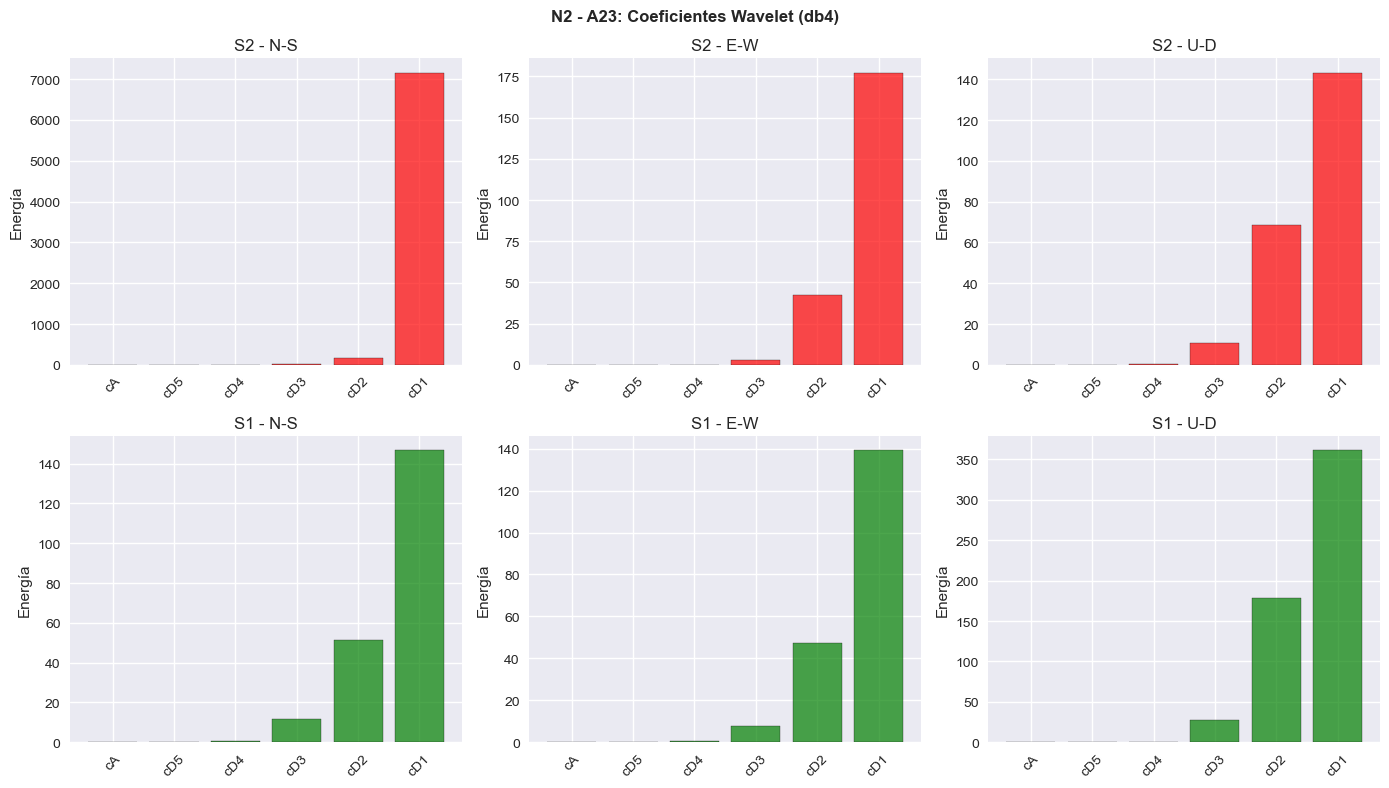

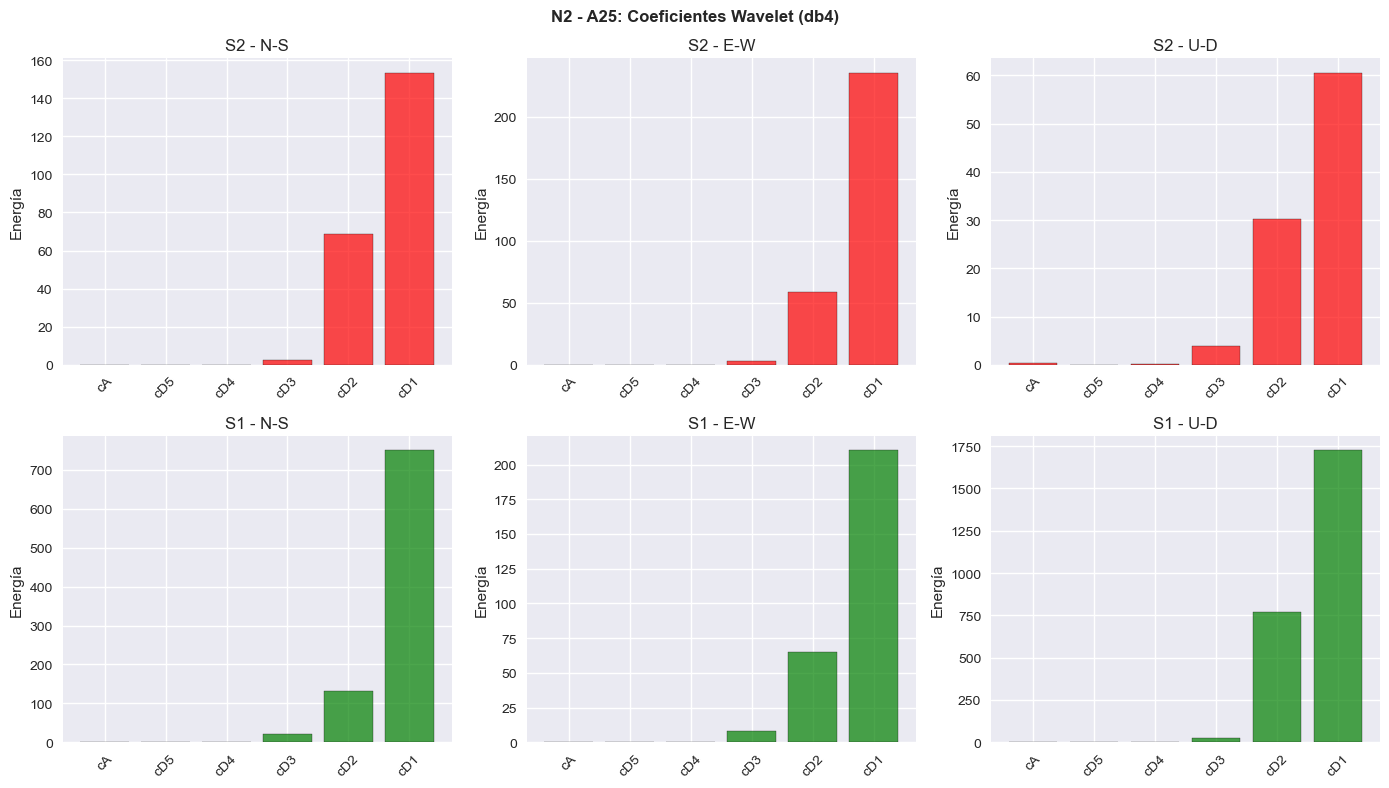

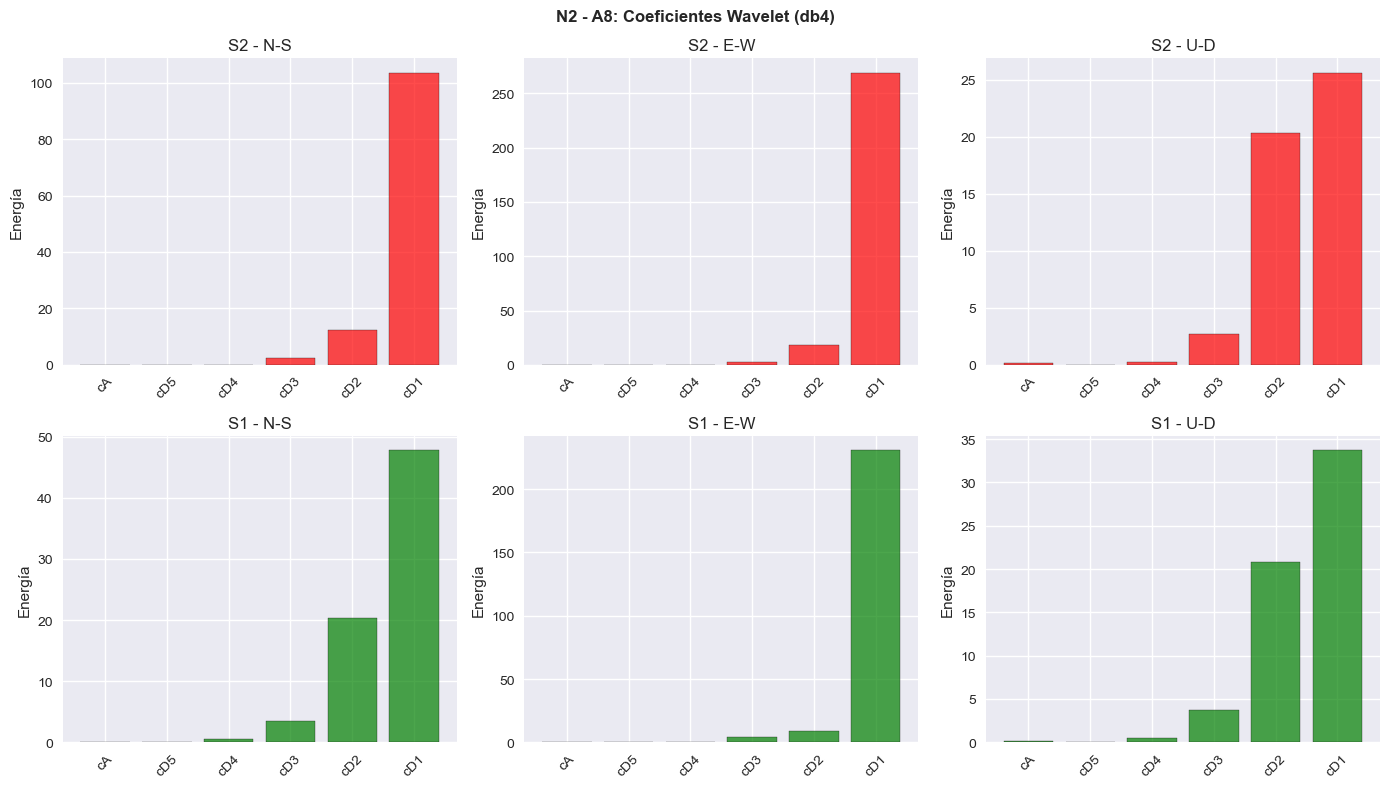

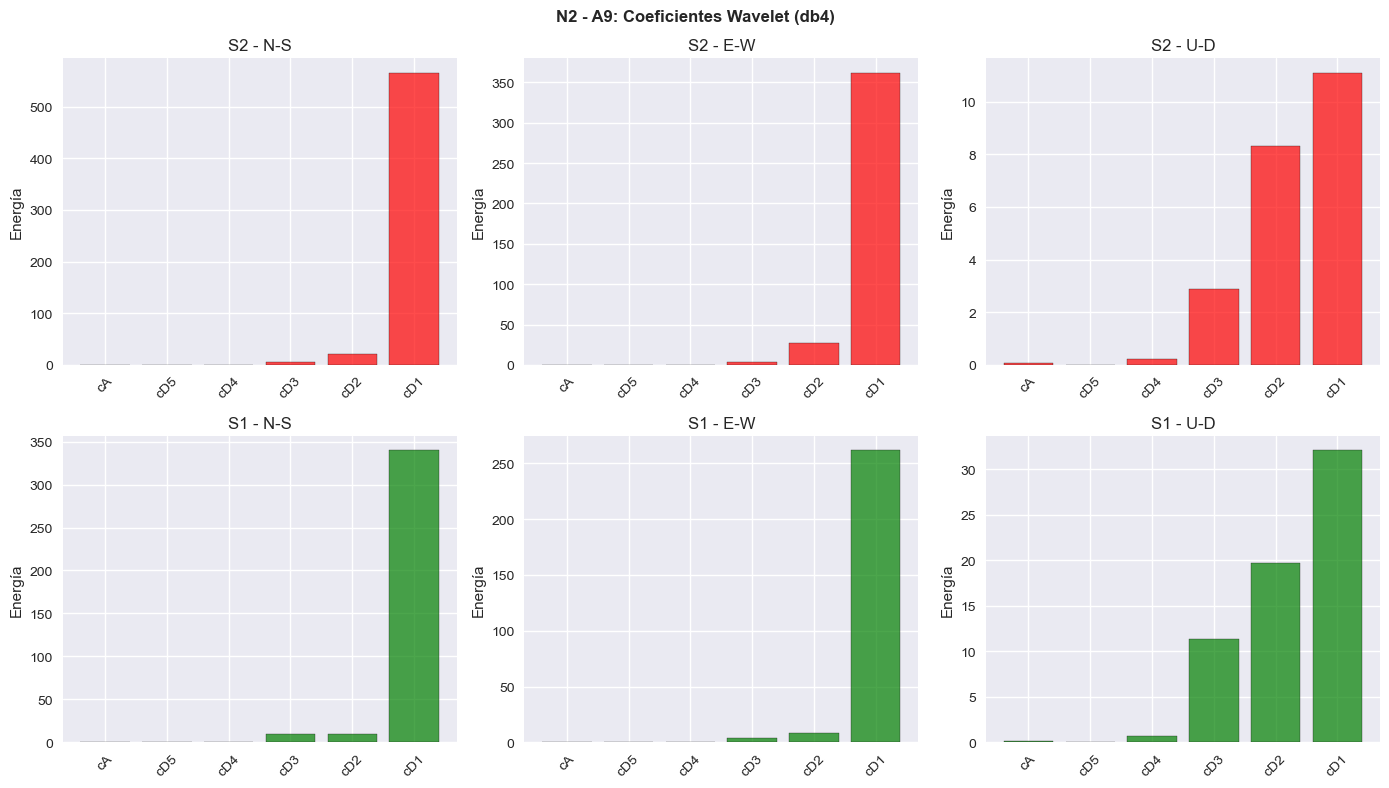

In [8]:
# Mismos especímenes que en notebook FFT para comparación justa
specimens_n2 = get_specimens_by_id(wavelet_data, ['A8', 'A9', 'A23', 'A25'])
print(f"Especímenes N2: {[s['specimen_id'] for s in specimens_n2]}\n")

for specimen in specimens_n2:
    plot_wavelet_coefficients(specimen)

### Coeficientes N3 (Daño severo)

Especímenes N3: ['A5', 'A6']



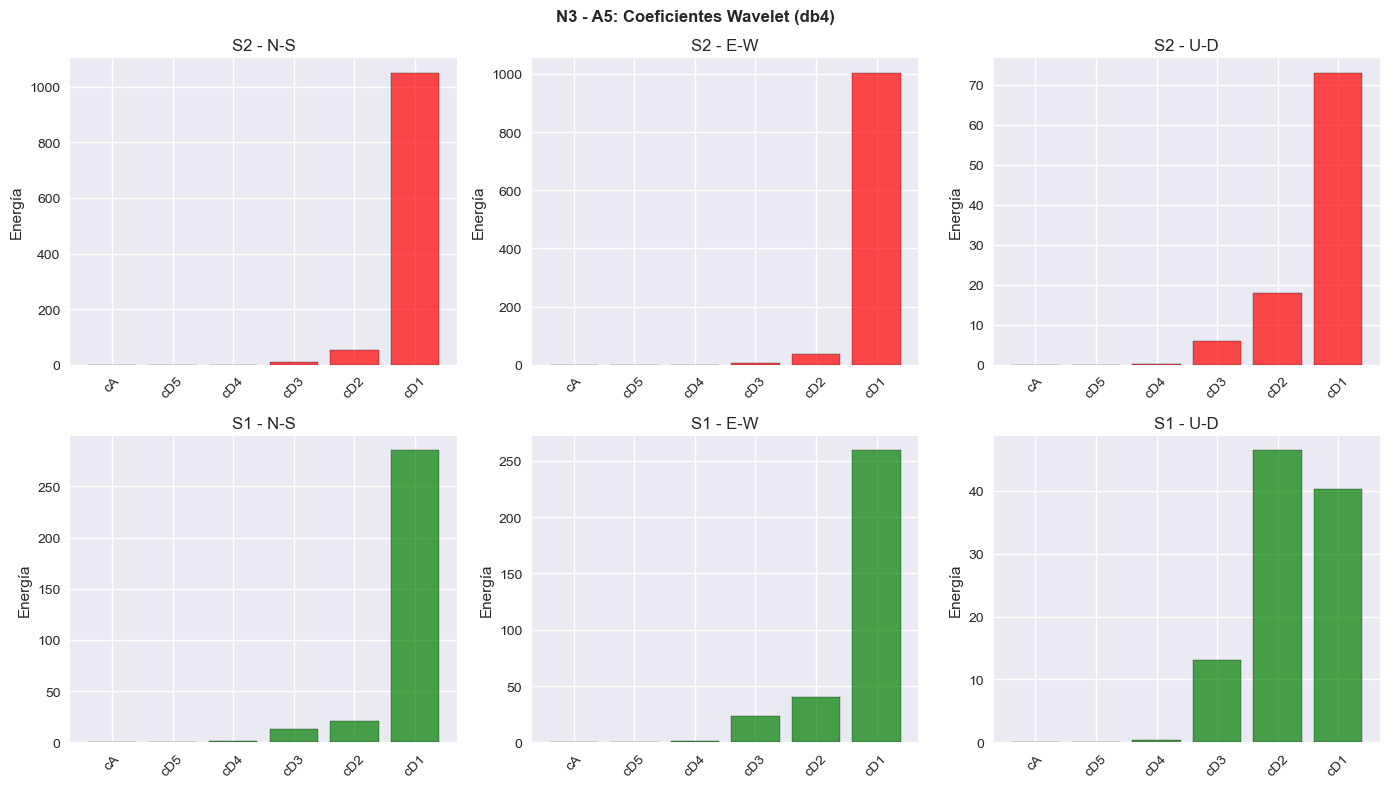

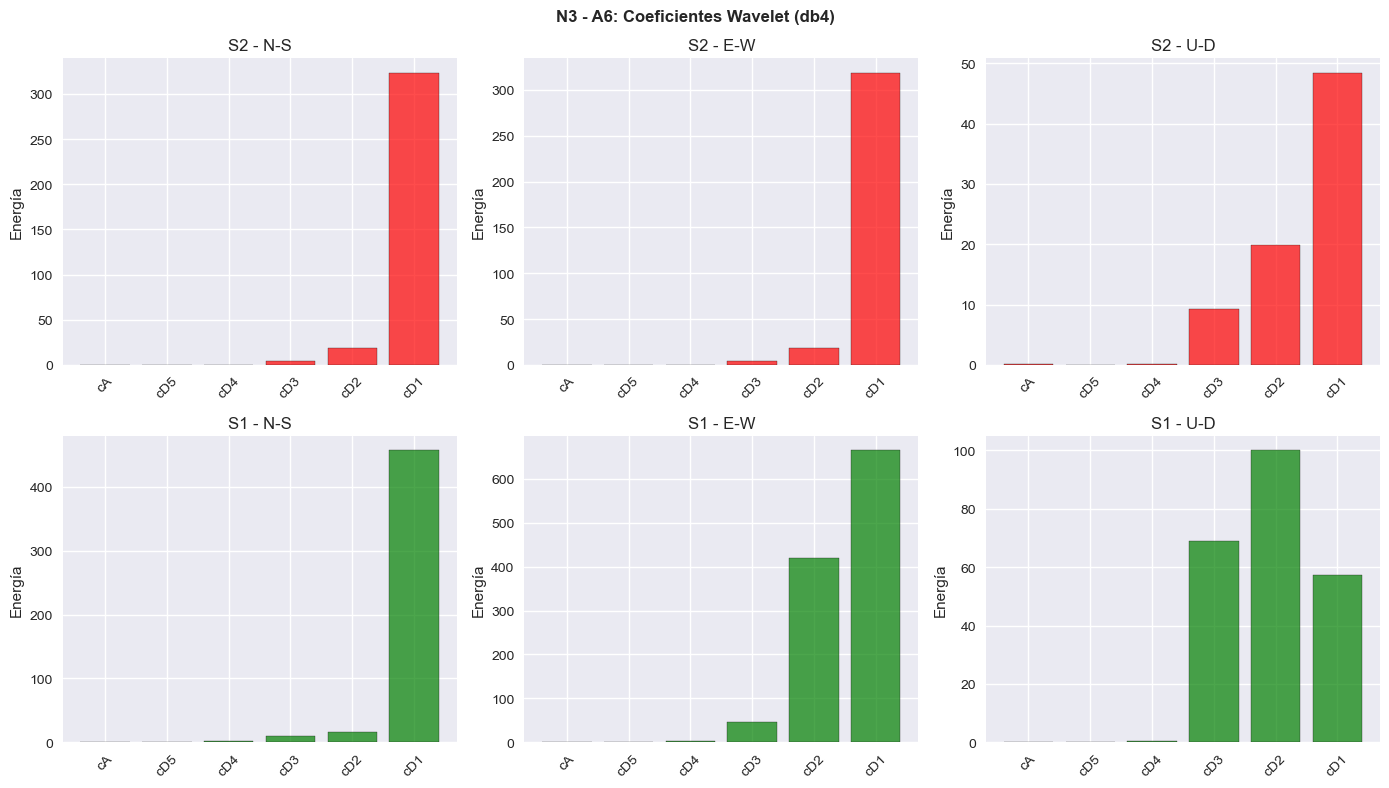

In [9]:
# Todos los N3 disponibles (solo hay 2: A5, A6)
specimens_n3 = get_specimens_by_damage(wavelet_data, 'N3', n=3)
print(f"Especímenes N3: {[s['specimen_id'] for s in specimens_n3]}\n")

for specimen in specimens_n3:
    plot_wavelet_coefficients(specimen)

## 4. Extracción de Features

In [10]:
# Extraer features con transfer features habilitados
features_matrix, features_df, feature_names = extract_wavelet_features(
    wavelet_data,
    include_transfer_features=False,
    verbose=True
)

print(f"\nMatriz de features: {features_matrix.shape}")
print(f"{features_matrix.shape[0]} especímenes × {features_matrix.shape[1]} características")

🔄 Extrayendo características de coeficientes wavelet...
   Include transfer features: False
   ✓ A1 (N1): 108 features
   ✓ A10 (N2): 108 features
   ✓ A11 (N2): 108 features
   ✓ A12 (N1): 108 features
   ✓ A13 (N1): 108 features
   ✓ A14 (N1): 108 features
   ✓ A15 (N1): 108 features
   ✓ A16 (N1): 108 features
   ✓ A17 (N1): 108 features
   ✓ A18 (N1): 108 features
   ✓ A19 (N1): 108 features
   ✓ A2 (N1): 108 features
   ✓ A20 (N1): 108 features
   ✓ A21 (N1): 108 features
   ✓ A22 (N1): 108 features
   ✓ A23 (N2): 108 features
   ✓ A24 (N1): 108 features
   ✓ A25 (N2): 108 features
   ✓ A26 (N1): 108 features
   ✓ A27 (N1): 108 features
   ✓ A28 (N1): 108 features
   ✓ A29 (N1): 108 features
   ✓ A3 (N1): 108 features
   ✓ A30 (N1): 108 features
   ✓ A31 (N1): 108 features
   ✓ A32 (N1): 108 features
   ✓ A33 (N1): 108 features
   ✓ A34 (N1): 108 features
   ✓ A35 (N1): 108 features
   ✓ A36 (N1): 108 features
   ✓ A37 (N1): 108 features
   ✓ A38 (N1): 108 features
   ✓ A39 (N1): 

### Características Extraídas

#### Features Base (por sensor, eje y nivel)
| Feature | Descripción |
|---------|-------------|
| `energy` | Energía del nivel (suma de coeficientes²) |
| `mean_abs` | Media del valor absoluto |
| `std` | Desviación estándar |

#### Features de Transferencia (S1/S2)
| Feature | Fórmula | Descripción |
|---------|---------|-------------|
| `ratio_energy` | energy(S1)/energy(S2) | Ratio de energías |
| `ratio_mean_abs` | mean_abs(S1)/mean_abs(S2) | Ratio de medias absolutas |
| `delta_energy` | energy(S1) - energy(S2) | Diferencia de energías |

## 5. Análisis de Clustering

### Normalización de Features

In [11]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

print(f"Features normalizadas: {features_normalized.shape}")
print(f"Media: {features_normalized.mean():.6f}, Std: {features_normalized.std():.6f}")

Features normalizadas: (51, 108)
Media: -0.000000, Std: 1.000000


### Método del Codo

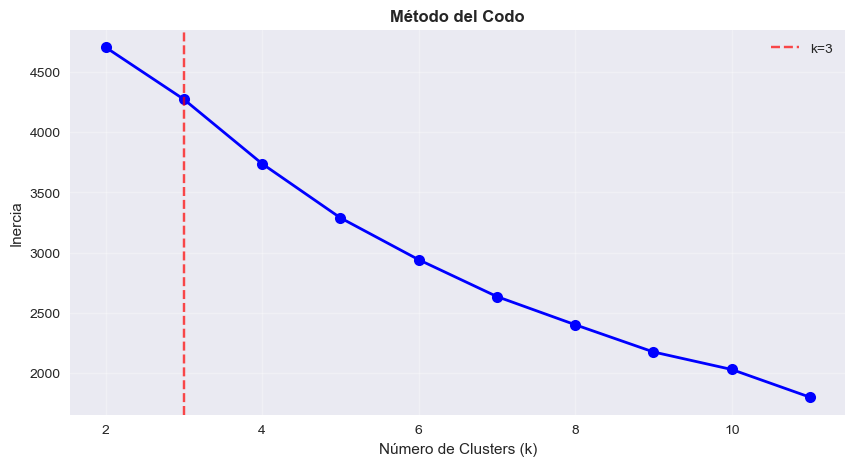

In [12]:
k_range = range(2, 12)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features_normalized)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Reducción de Dimensionalidad (PCA)

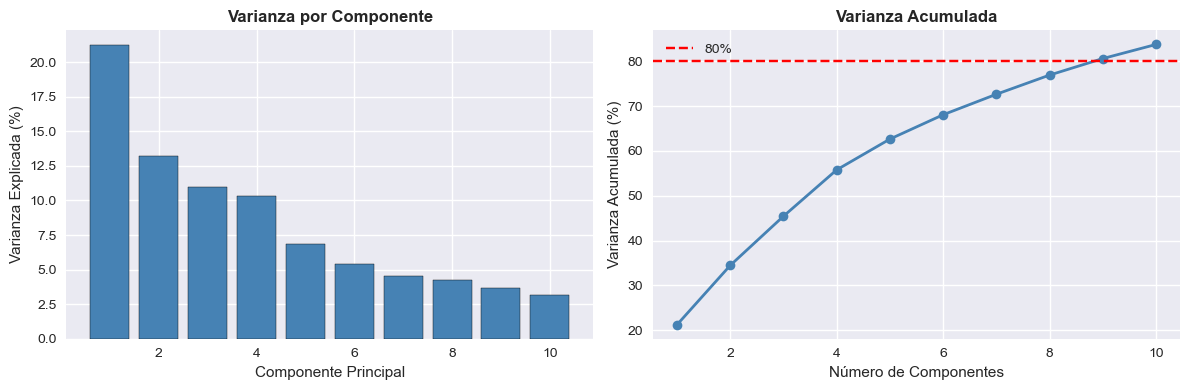

PC1+PC2: 34.5%


In [13]:
# Scree plot
pca_full = PCA().fit(features_normalized)
var_explicada = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

n_comp = min(10, len(var_explicada))
axes[0].bar(range(1, n_comp + 1), var_explicada[:n_comp] * 100, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].set_title('Varianza por Componente', fontweight='bold')

axes[1].plot(range(1, n_comp + 1), var_acumulada[:n_comp] * 100, 'o-', color='steelblue', linewidth=2)
axes[1].axhline(y=80, color='red', linestyle='--', label='80%')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada (%)')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"PC1+PC2: {var_acumulada[1]*100:.1f}%")

In [14]:
# PCA 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}")

Varianza explicada: 34.5%


### Visualización de Datos Reales

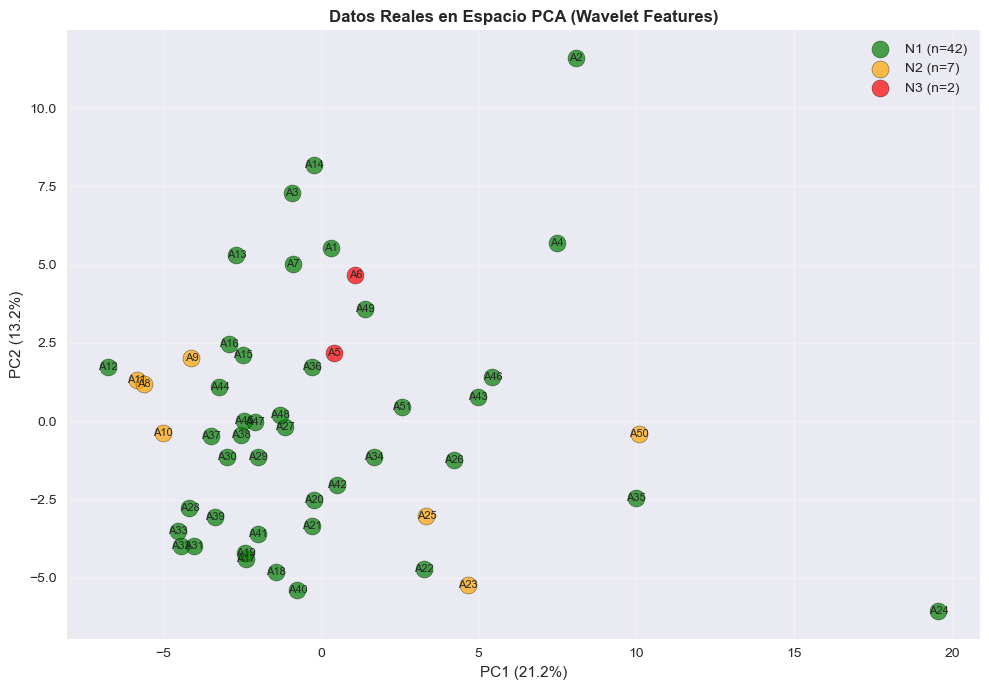

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

colors_real = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}

for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:
        continue
    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
               c=colors_real[nivel], label=f'{nivel} (n={mask.sum()})',
               s=150, alpha=0.7, edgecolors='black')
    
    for i, sid in enumerate(specimen_ids[mask]):
        ax.annotate(sid, (features_pca[mask, 0][i], features_pca[mask, 1][i]),
                    fontsize=8, ha='center', va='center')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Datos Reales en Espacio PCA (Wavelet Features)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Aplicación de K-Means (k=3)

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

features_df['cluster'] = cluster_labels

print("Cluster vs Nivel de Daño:")
print(pd.crosstab(labels_real, cluster_labels, rownames=['Nivel'], colnames=['Cluster']))

Cluster vs Nivel de Daño:
Cluster   0  1   2
Nivel             
N1       15  2  25
N2        1  2   4
N3        2  0   0


### Visualización de Clusters

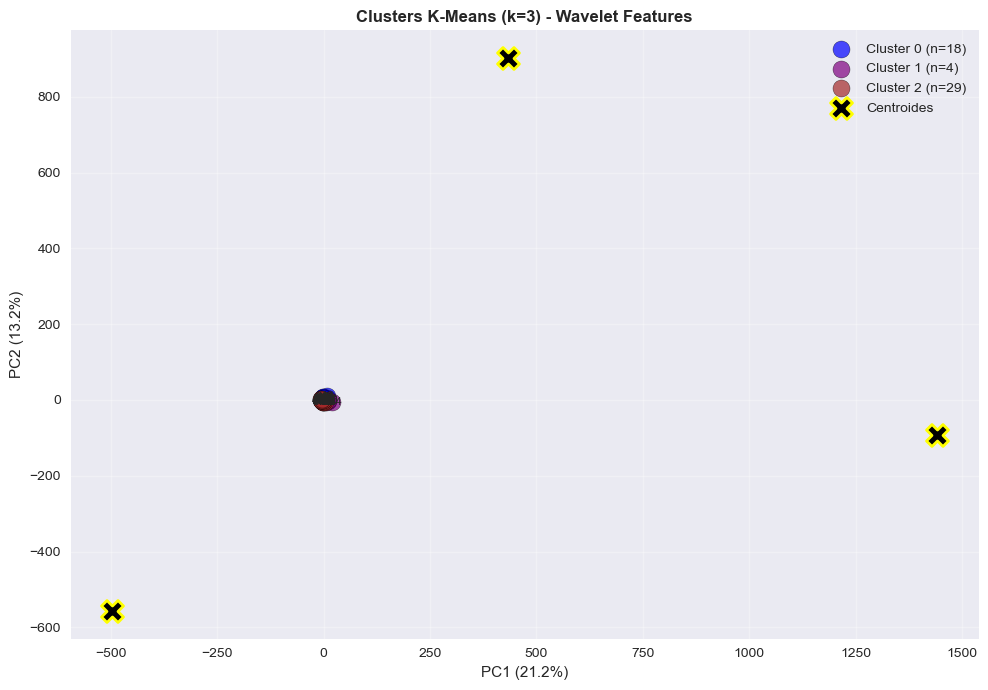

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

colors_cluster = {0: 'blue', 1: 'purple', 2: 'brown'}

for c in range(3):
    mask = cluster_labels == c
    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
               c=colors_cluster[c], label=f'Cluster {c} (n={mask.sum()})',
               s=150, alpha=0.7, edgecolors='black')
    
    for i, sid in enumerate(specimen_ids[mask]):
        ax.annotate(sid, (features_pca[mask, 0][i], features_pca[mask, 1][i]),
                    fontsize=8, ha='center', va='center')

# Centroides
centroids_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='black', marker='X', s=250, edgecolors='yellow', linewidths=2,
           label='Centroides', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Clusters K-Means (k=3) - Wavelet Features', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Métricas de Evaluación

In [18]:
metrics = evaluate_clustering(
    features=features_normalized,
    cluster_labels=cluster_labels,
    labels_real=labels_real,
    kmeans_model=kmeans,
    experiment_name="Wavelet (db4) + K-Means (k=3) con transfer features"
)

📊 MÉTRICAS: Wavelet (db4) + K-Means (k=3) con transfer features

🔹 Intrínsecas:
   Inertia:              4272.13
   Silhouette:            0.1774  [-1, 1] ↑
   Davies-Bouldin:        2.1804  [0, ∞) ↓
   Calinski-Harabasz:       6.94  [0, ∞) ↑

🔹 Extrínsecas (51/51 con etiqueta):
   ARI:                   0.0683  [-1, 1] ↑
   NMI:                   0.1112  [0, 1] ↑
   Homogeneity:           0.1439  [0, 1] ↑
   Completeness:          0.0907  [0, 1] ↑
   V-Measure:             0.1112  [0, 1] ↑


### Registro del Experimento

In [19]:
logger.log_experiment(
    experiment_id="wavelet_kmeans_k3_db4_transfer",
    notebook_name="3_clustering_wavelet_kmeans",
    algorithm="kmeans",
    frequency_transform="wavelet",
    n_clusters=3,
    pca_dims=2,
    feature_set="wavelet_db4_level5_with_transfer",
    
    inertia=metrics.get('inertia'),
    silhouette_score=metrics.get('silhouette'),
    davies_bouldin_index=metrics.get('davies_bouldin'),
    calinski_harabasz_score=metrics.get('calinski'),
    
    adjusted_rand_index=metrics.get('ari'),
    normalized_mutual_info=metrics.get('nmi'),
    homogeneity=metrics.get('homogeneity'),
    completeness=metrics.get('completeness'),
    v_measure=metrics.get('v_measure'),
    
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="Wavelet db4 level=5 + transfer features + K-Means k=3"
)

print(f"\n✅ Experimento registrado en: {RESULTS_FILE}")

📊 Experimento registrado: 3_clustering_wavelet_kmeans | kmeans | wavelet (ID: wavelet_kmeans_k3_db4_transfer)

✅ Experimento registrado en: clustering_experiments.csv
